In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
print("yes")

In [3]:
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [4]:
# Define the time period (3 years of data)
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

# Download stock data (using Apple as an example, but you can change this)
ticker = 'AAPL'  # You can change this to any stock symbol
print(f"Downloading data for {ticker} from {start_date.date()} to {end_date.date()}")

# Download using yfinance
data = yf.download(ticker, start=start_date, end=end_date)

# Display first few rows
print("\nFirst 5 rows of the data:")
display(data.head())

# Check data shape
print(f"\nDataset shape: {data.shape}")

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Display basic statistics
print("\nBasic statistics of the data:")
display(data.describe())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


First 5 rows of the data:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2022-03-10,155.992386,157.832564,153.492878,157.645591,105342000
2022-03-11,152.262787,156.740239,152.036458,156.395814,96970100
2022-03-14,148.218292,151.662483,147.706595,149.035059,108732100
2022-03-15,152.617050,153.089407,147.982161,148.493858,92964300
2022-03-16,157.045319,157.448785,151.997127,154.545826,102300200



Dataset shape: (751, 5)

Missing values in each column:
Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

Basic statistics of the data:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,751.000000,751.000000,751.000000,751.000000,7.510000e+02
mean,180.950489,182.649261,179.016250,180.730941,6.549856e+07
std,32.613782,32.661306,32.449529,32.563654,2.744324e+07
min,123.583107,126.301500,122.742880,124.561717,2.323470e+07
25%,153.992836,155.727361,151.873403,153.634875,4.747165e+07
50%,175.252487,176.655854,173.528191,175.096694,5.895310e+07
75%,196.310677,196.728720,193.952186,195.379698,7.636415e+07
max,258.735504,259.814335,257.347047,257.906429,3.186799e+08


In [11]:
# Clear any previous data to avoid conflicts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Define the time period (3 years of data)
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

# Download stock data
ticker = 'AAPL'
print(f"Downloading data for {ticker} from {start_date.date()} to {end_date.date()}")
data = yf.download(ticker, start=start_date, end=end_date)

# Check if columns are MultiIndex and fix if needed
if isinstance(data.columns, pd.MultiIndex):
    print("Detected MultiIndex columns - fixing...")
    data.columns = data.columns.droplevel(1)  # Drop the ticker level

# Verify data after fixing
print(f"Dataset shape after download: {data.shape}")
print("Columns:", list(data.columns))

# Make a copy to avoid modification warnings
df = data.copy()

# Calculate basic indicators one by one with verification
print("Calculating indicators...")

# Daily returns
df['Return'] = df['Close'].pct_change()
print("Return calculated ✓")

# Target variable
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
print("Target calculated ✓")

# Moving Averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()
print("Moving averages calculated ✓")

# Exponential Moving Averages
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
print("EMAs calculated ✓")

# MACD
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
print("MACD calculated ✓")

# RSI
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))
print("RSI calculated ✓")

# Bollinger Bands
df['MA_20_std'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['MA_20'] + (df['MA_20_std'] * 2)
df['Lower_Band'] = df['MA_20'] - (df['MA_20_std'] * 2)
df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA_20']
print("Bollinger Bands calculated ✓")

# Safely calculate BB Position indicators
df['Price_Above_MA20'] = (df['Close'] > df['MA_20']).astype(int)
df['Price_Above_Upper'] = (df['Close'] > df['Upper_Band']).astype(int)
df['Price_Below_Lower'] = (df['Close'] < df['Lower_Band']).astype(int)
print("BB position indicators calculated ✓")

# ATR
df['High_Low'] = df['High'] - df['Low']
df['High_PrevClose'] = abs(df['High'] - df['Close'].shift(1))
df['Low_PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['High_Low', 'High_PrevClose', 'Low_PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()
print("ATR calculated ✓")

# OBV
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
print("OBV calculated ✓")

# Price Rate of Change
df['ROC_5'] = df['Close'].pct_change(periods=5) * 100
df['ROC_10'] = df['Close'].pct_change(periods=10) * 100
print("ROC calculated ✓")

# MA Crossovers
df['MA_Cross_5_20'] = (df['MA_5'] > df['MA_20']).astype(int)
df['MA_Cross_20_50'] = (df['MA_20'] > df['MA_50']).astype(int)
print("MA crossovers calculated ✓")

# VWAP
df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
print("VWAP calculated ✓")

# Drop NaN values
df_clean = df.dropna()
print(f"Final shape after dropping NaN values: {df_clean.shape}")

# Display the first 5 rows of clean data
print("\nFirst 5 rows after feature engineering:")
display(df_clean.head())

# Show all features created
print("\nFeatures created:")
print(list(df_clean.columns))

# Replace the original data with clean data for further analysis
data = df_clean.copy()

[*********************100%***********************]  1 of 1 completed

Detected MultiIndex columns - fixing...
Dataset shape after download: (751, 5)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Calculating indicators...
Return calculated ✓
Target calculated ✓
Moving averages calculated ✓
EMAs calculated ✓
MACD calculated ✓
RSI calculated ✓
Bollinger Bands calculated ✓
BB position indicators calculated ✓
ATR calculated ✓
OBV calculated ✓
ROC calculated ✓
MA crossovers calculated ✓
VWAP calculated ✓
Final shape after dropping NaN values: (552, 37)

First 5 rows after feature engineering:


Price,Close,High,Low,Open,Volume,Return,Target,MA_5,MA_20,MA_50,...,High_PrevClose,Low_PrevClose,TR,ATR,OBV,ROC_5,ROC_10,MA_Cross_5_20,MA_Cross_20_50,VWAP
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-22,130.710220,133.013442,128.802410,132.805865,77852100,-0.023773,0,131.839111,139.847498,142.618618,...,0.879807,5.090840,5.090840,4.506181,-227590900.0,-3.128223,-7.304608,0,0,149.535554
2022-12-23,130.344498,130.898059,128.150012,129.415299,63814900,-0.002798,0,131.315204,139.044337,142.403258,...,0.187839,2.560209,2.748047,4.338841,-291405800.0,-1.970110,-7.245361,0,0,149.465088
2022-12-27,128.535507,129.899651,127.240566,129.869997,69007800,-0.013879,0,130.852582,138.342991,142.242708,...,0.444847,3.103932,3.103932,4.180682,-360413600.0,-1.767776,-10.007625,0,0,149.382314
2022-12-28,124.591377,129.524023,124.423333,128.179654,85438400,-0.030685,1,129.614970,137.595186,141.923734,...,0.988516,4.112174,5.100690,4.307069,-445852000.0,-4.731674,-13.356708,0,0,149.261516
2022-12-29,128.120331,128.980327,126.261941,126.518948,75703700,0.028324,1,128.460387,136.684771,141.648890,...,4.388949,1.670564,4.388949,4.438398,-370148300.0,-4.311583,-9.496557,0,0,149.170631



Features created:
['Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'Target', 'MA_5', 'MA_20', 'MA_50', 'MA_200', 'EMA_5', 'EMA_20', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'MACD_Histogram', 'RSI', 'MA_20_std', 'Upper_Band', 'Lower_Band', 'BB_Width', 'Price_Above_MA20', 'Price_Above_Upper', 'Price_Below_Lower', 'High_Low', 'High_PrevClose', 'Low_PrevClose', 'TR', 'ATR', 'OBV', 'ROC_5', 'ROC_10', 'MA_Cross_5_20', 'MA_Cross_20_50', 'VWAP']


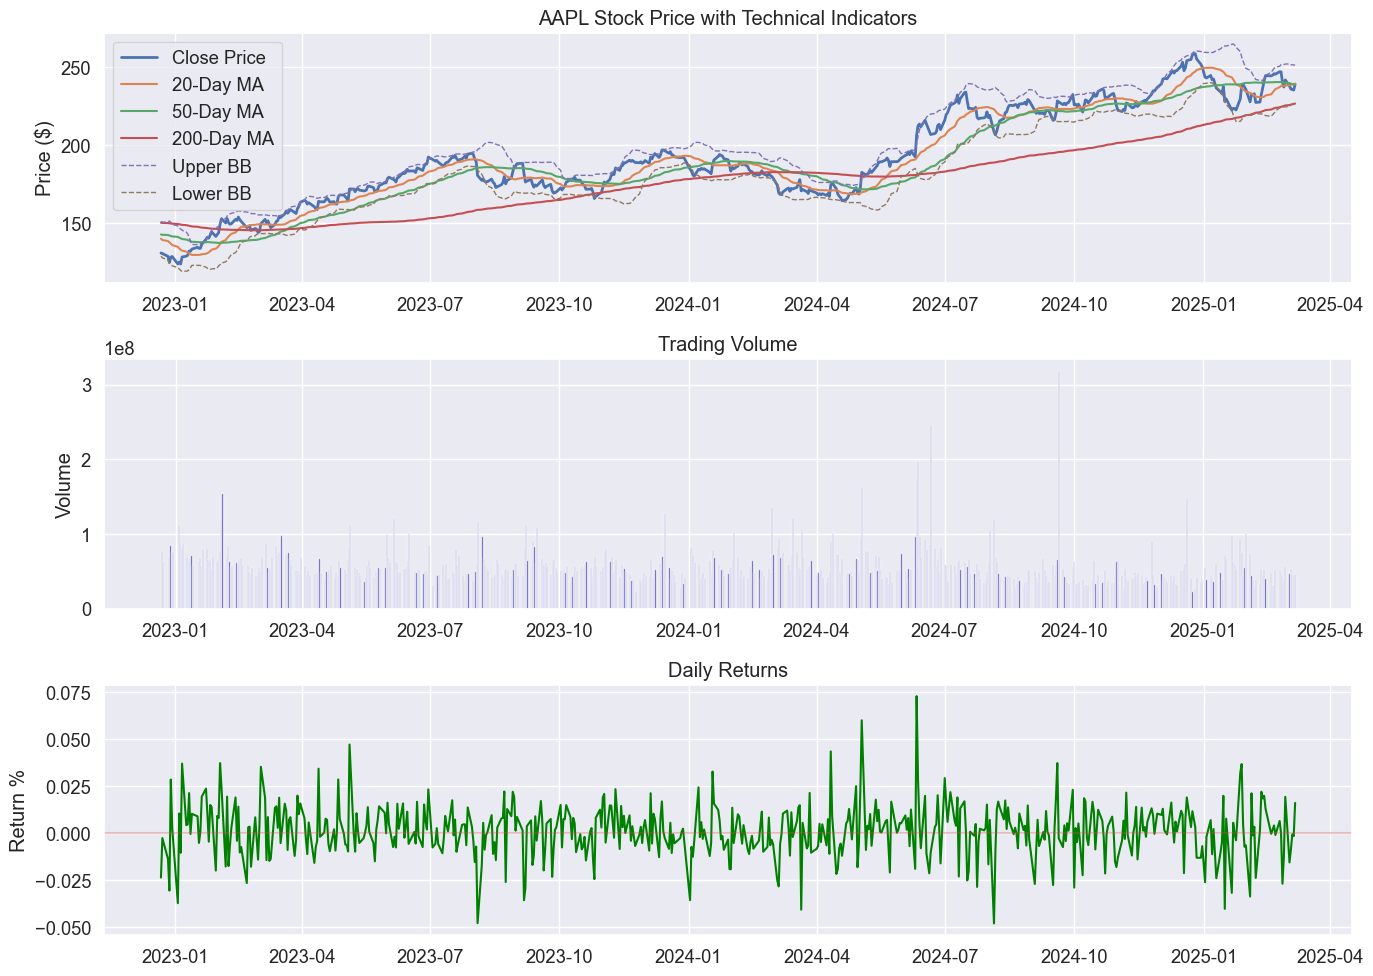

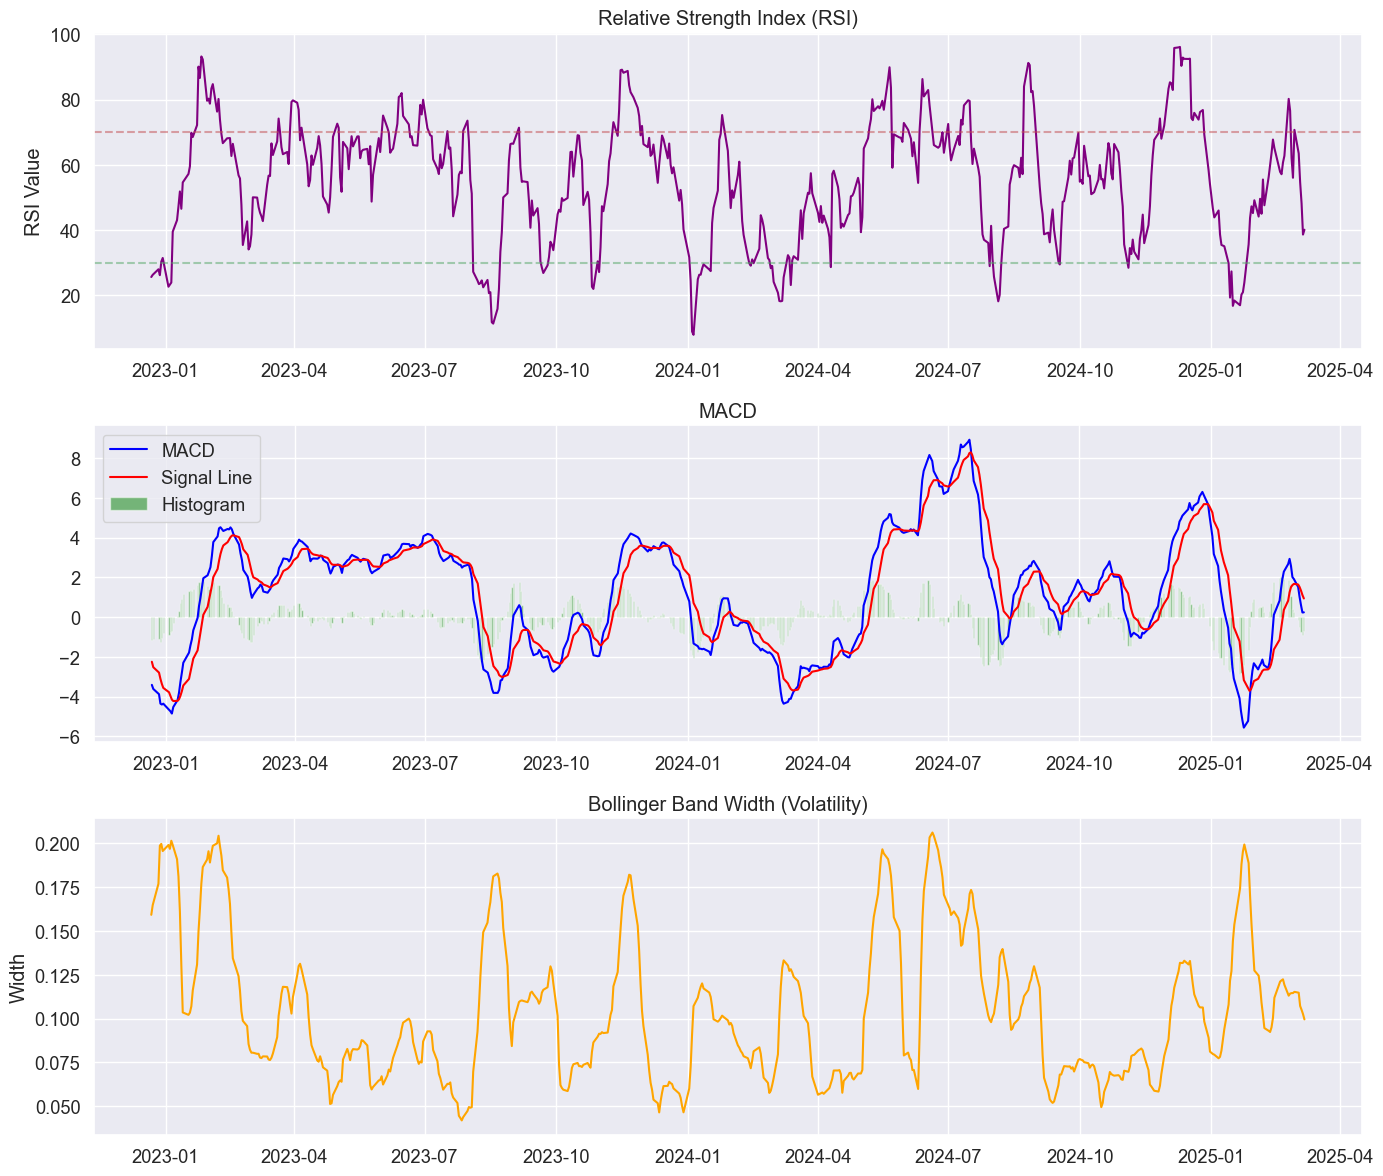

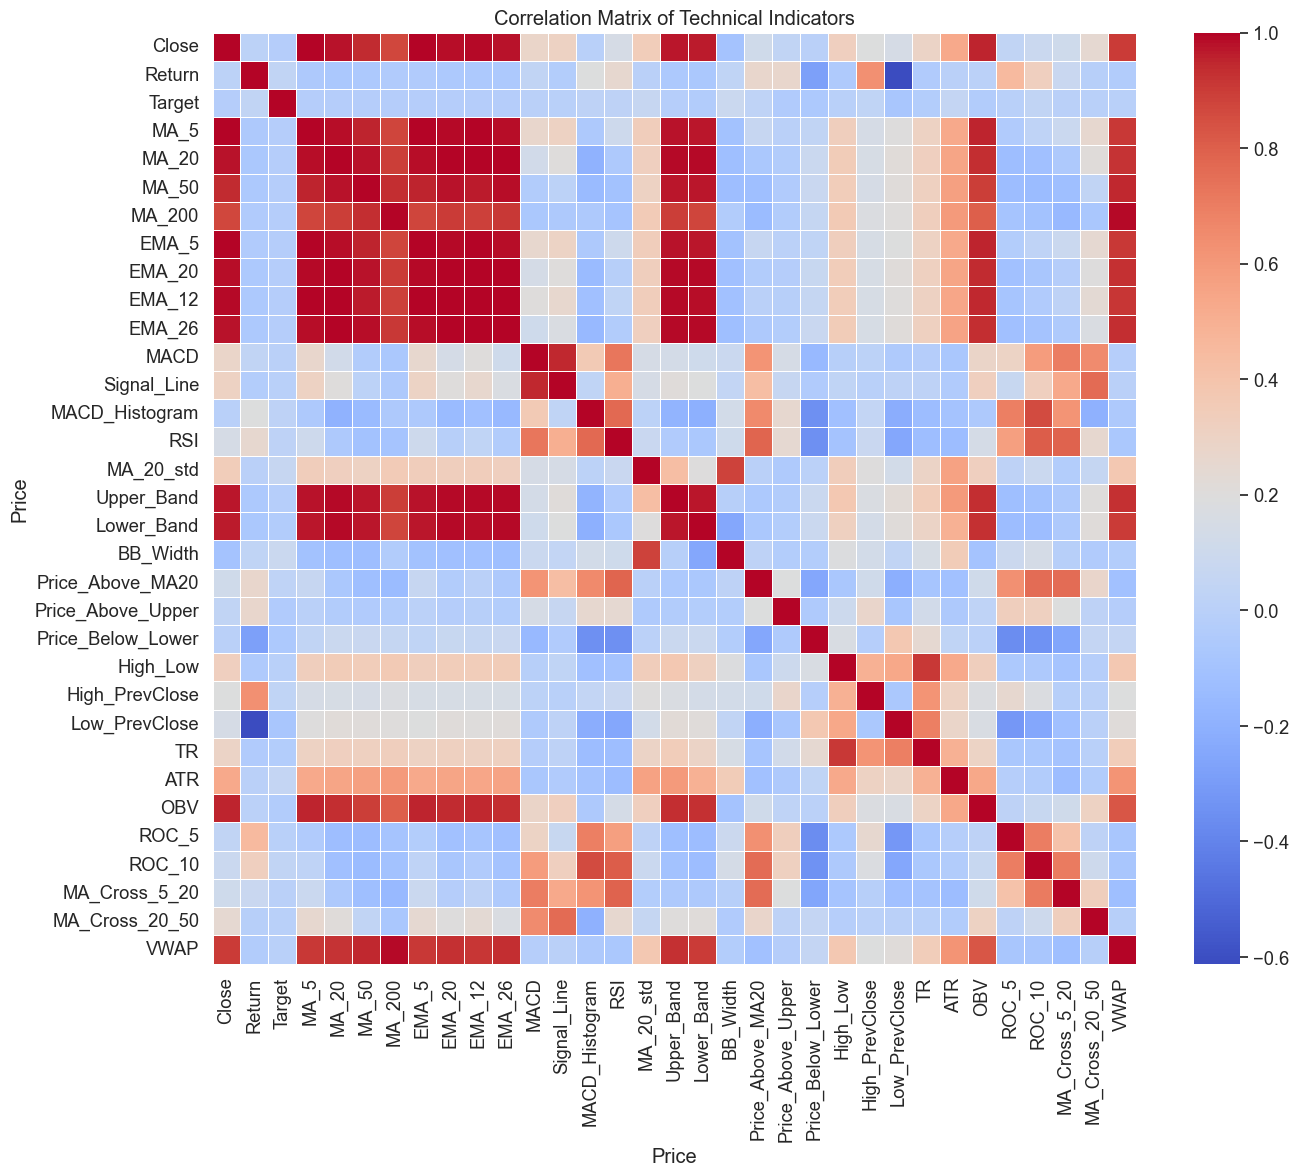

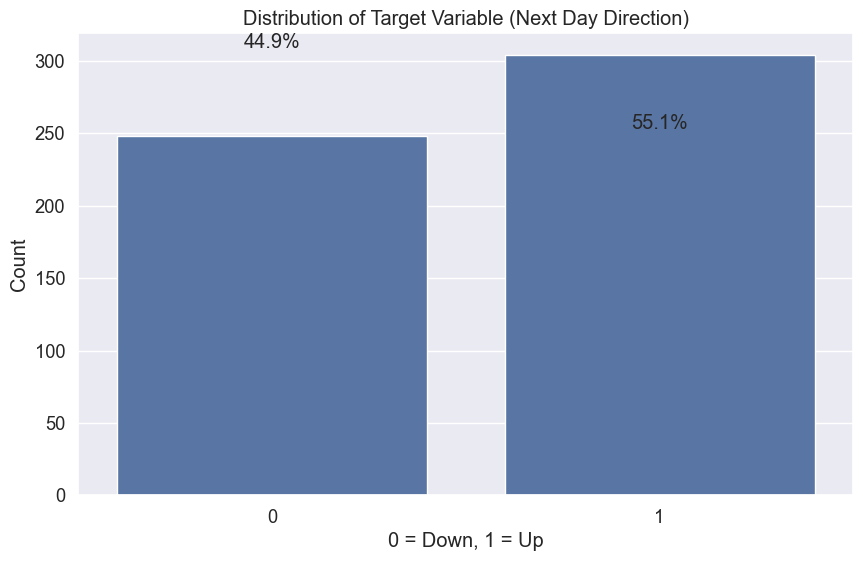

In [12]:
# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.figure(figsize=(14, 10))

# 1. Plot stock price with key technical indicators
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price', linewidth=2)
plt.plot(data.index, data['MA_20'], label='20-Day MA', linewidth=1.5)
plt.plot(data.index, data['MA_50'], label='50-Day MA', linewidth=1.5)
plt.plot(data.index, data['MA_200'], label='200-Day MA', linewidth=1.5)
plt.plot(data.index, data['Upper_Band'], label='Upper BB', linestyle='--', linewidth=1)
plt.plot(data.index, data['Lower_Band'], label='Lower BB', linestyle='--', linewidth=1)
plt.title(f'{ticker} Stock Price with Technical Indicators')
plt.ylabel('Price ($)')
plt.legend()

# 2. Plot trading volume
plt.subplot(3, 1, 2)
plt.bar(data.index, data['Volume'], color='darkblue', alpha=0.7)
plt.title('Trading Volume')
plt.ylabel('Volume')

# 3. Plot daily returns distribution
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Return'], color='green', label='Daily Returns')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Daily Returns')
plt.ylabel('Return %')
plt.tight_layout()
plt.show()

# Additional visualization: Oscillators
plt.figure(figsize=(14, 12))

# 1. RSI
plt.subplot(3, 1, 1)
plt.plot(data.index, data['RSI'], color='purple', linewidth=1.5)
plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)
plt.title('Relative Strength Index (RSI)')
plt.ylabel('RSI Value')

# 2. MACD
plt.subplot(3, 1, 2)
plt.plot(data.index, data['MACD'], label='MACD', color='blue', linewidth=1.5)
plt.plot(data.index, data['Signal_Line'], label='Signal Line', color='red', linewidth=1.5)
plt.bar(data.index, data['MACD_Histogram'], label='Histogram', color='green', alpha=0.5)
plt.title('MACD')
plt.legend()

# 3. Bollinger Band Width
plt.subplot(3, 1, 3)
plt.plot(data.index, data['BB_Width'], color='orange', linewidth=1.5)
plt.title('Bollinger Band Width (Volatility)')
plt.ylabel('Width')
plt.tight_layout()
plt.show()

# Correlation heatmap of features
plt.figure(figsize=(14, 12))
correlation_matrix = data.drop(['Open', 'High', 'Low', 'Volume'], axis=1).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Technical Indicators')
plt.tight_layout()
plt.show()

# Distribution of Target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='Target', data=data)
plt.title('Distribution of Target Variable (Next Day Direction)')
plt.xlabel('0 = Down, 1 = Up')
plt.ylabel('Count')
target_pct = data['Target'].value_counts(normalize=True) * 100
for i, v in enumerate(data['Target'].value_counts()):
    plt.text(i, v + 5, f"{target_pct[i]:.1f}%", ha='center')
plt.show()

Training data shape: (441, 31)
Testing data shape: (111, 31)

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.5405
Precision: 0.5849
Recall: 0.5167
F1 Score: 0.5487


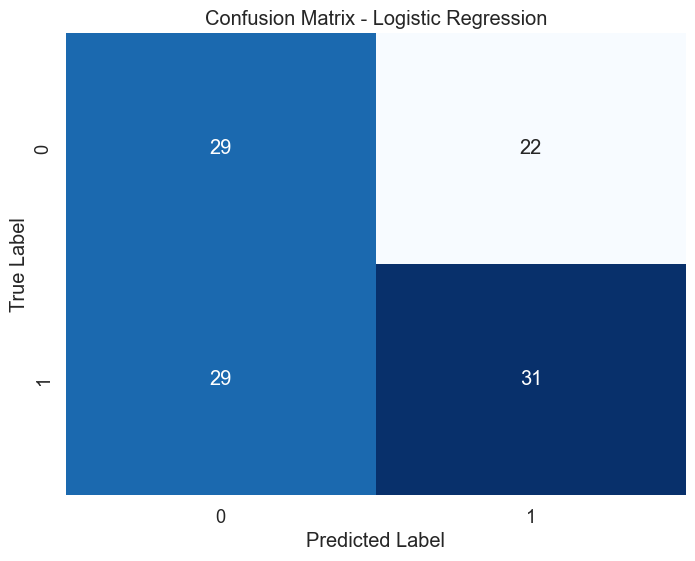

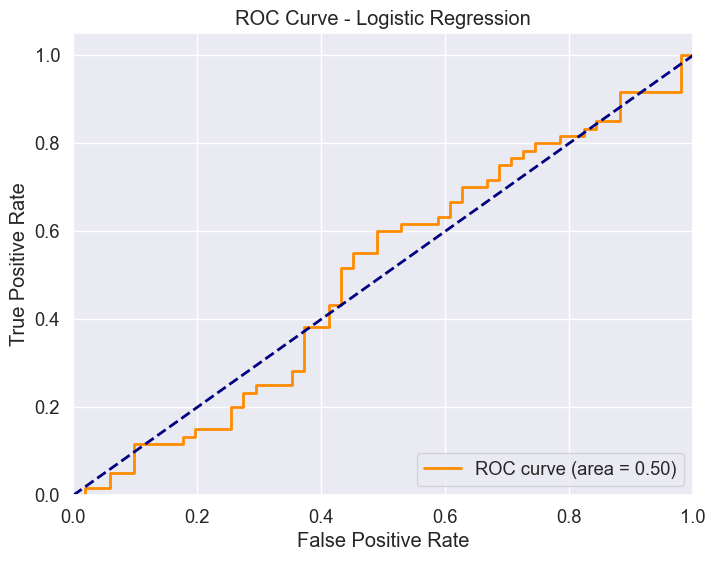


Training Random Forest...
Random Forest Results:
Accuracy: 0.4865
Precision: 0.6154
Recall: 0.1333
F1 Score: 0.2192


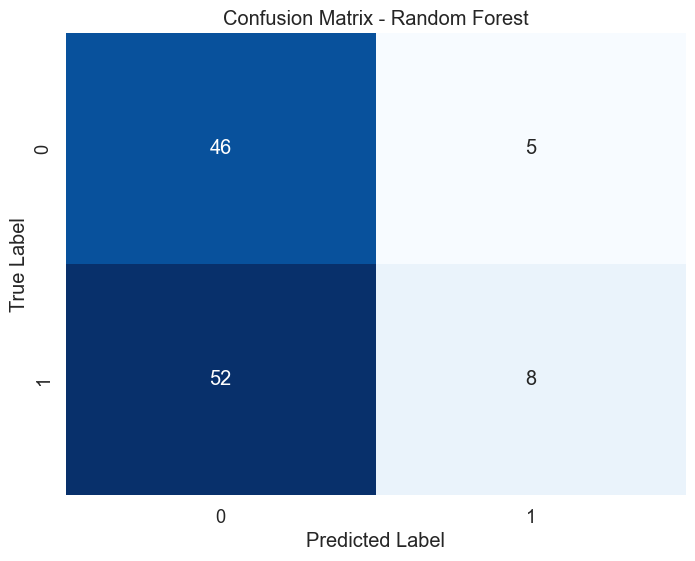

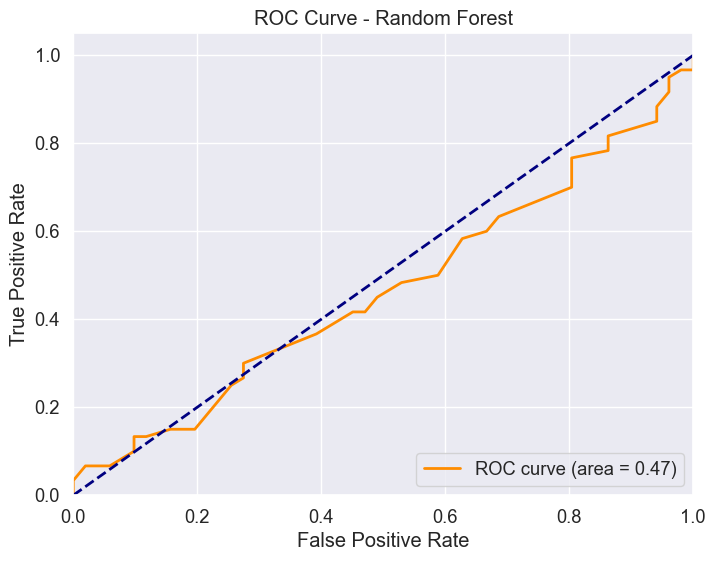


Training XGBoost...
XGBoost Results:
Accuracy: 0.4775
Precision: 0.5278
Recall: 0.3167
F1 Score: 0.3958


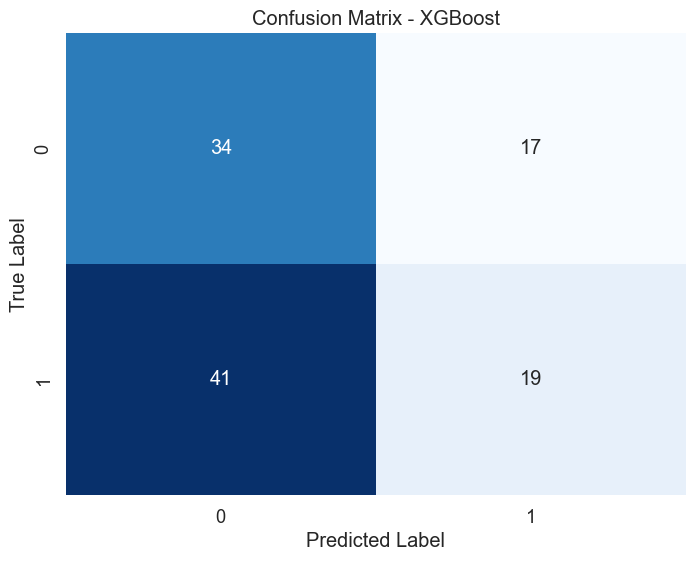

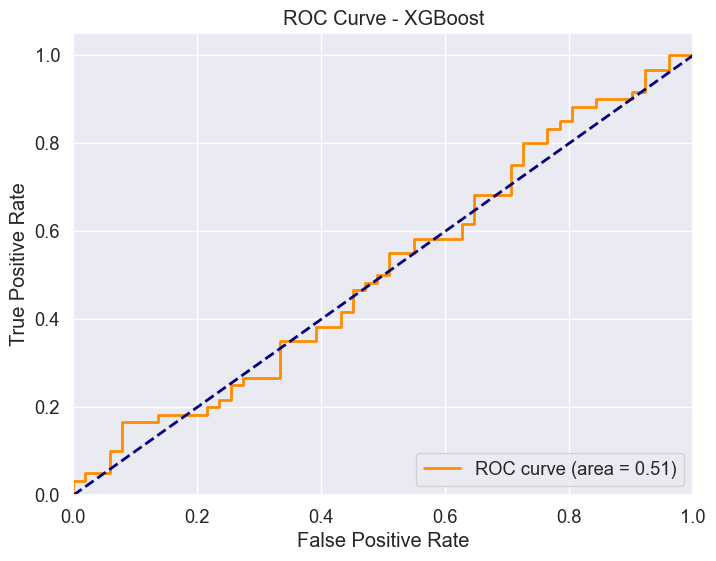

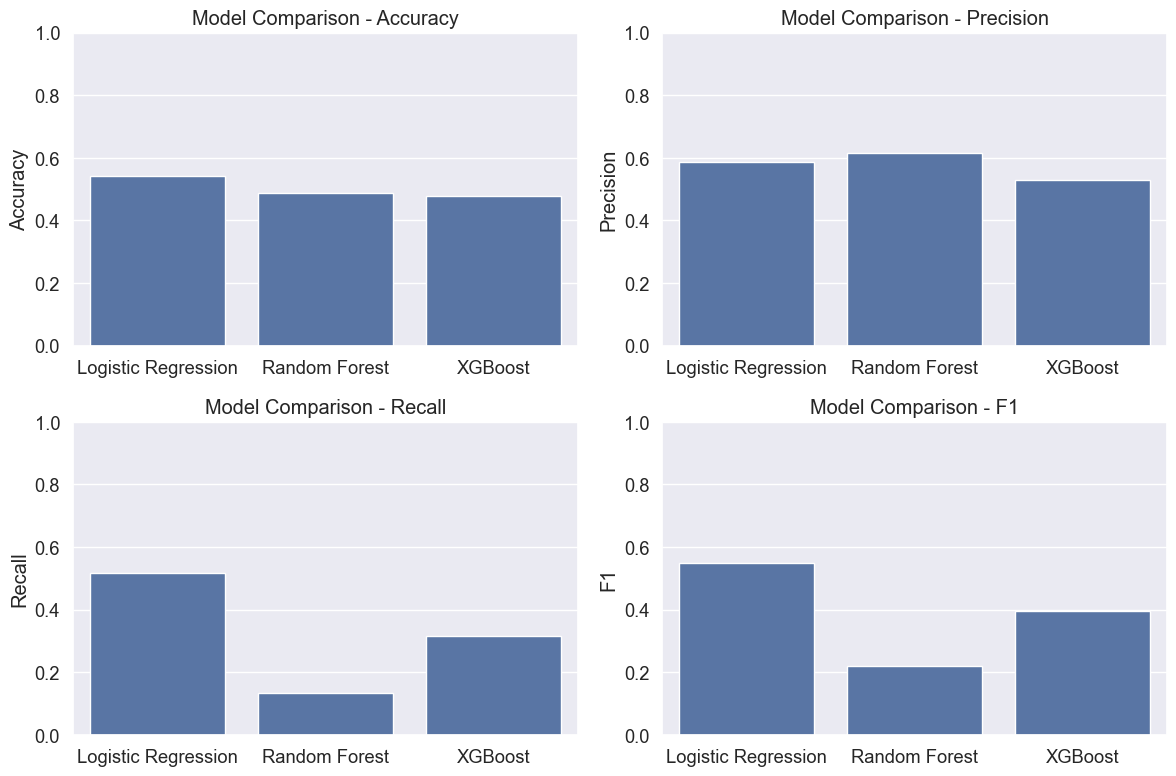


Best Model: Logistic Regression with F1 score of 0.5487


In [14]:
# Import required libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import xgboost as xgb

# Prepare the data for modeling
# Select features (excluding price data and target)
feature_columns = [col for col in data.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 'Target']]

# Add some derivative features that might help
data['RSI_Oversold'] = (data['RSI'] < 30).astype(int)
data['RSI_Overbought'] = (data['RSI'] > 70).astype(int)

# Define features and target
X = data[feature_columns]
y = data['Target']

# Split the data: use the first 80% for training and the last 20% for testing
# For time series data, we don't want to shuffle
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate and store metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model,
        'predictions': y_pred
    }
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

# Compare model performance
model_names = list(results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1']

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    values = [results[model][metric] for model in model_names]
    sns.barplot(x=model_names, y=values)
    plt.title(f'Model Comparison - {metric.capitalize()}')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1)
    
plt.tight_layout()
plt.show()

# Identify the best model based on F1 score
best_model_name = max(results, key=lambda x: results[x]['f1'])
print(f"\nBest Model: {best_model_name} with F1 score of {results[best_model_name]['f1']:.4f}")

# Feature importance for the best model (if available)
best_model = results[best_model_name]['model']

if best_model_name == 'Random Forest' or best_model_name == 'XGBoost':
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importances')
        plt.bar(range(X_train.shape[1]), importances[indices], align='center')
        plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        for i in range(min(10, X_train.shape[1])):
            print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")


Backtesting Trading Strategy using Logistic Regression

Performance Summary:
Total Period: 2024-09-26 to 2025-03-07
Trading Days: 111

Total Return:
  Market: 5.84%
  Strategy: 4.39%

Annualized Return:
  Market: 13.76%
  Strategy: 10.24%

Annualized Volatility:
  Market: 21.98%
  Strategy: 22.20%

Sharpe Ratio:
  Market: 0.63
  Strategy: 0.46

Maximum Drawdown:
  Market: -14.05%
  Strategy: -11.45%


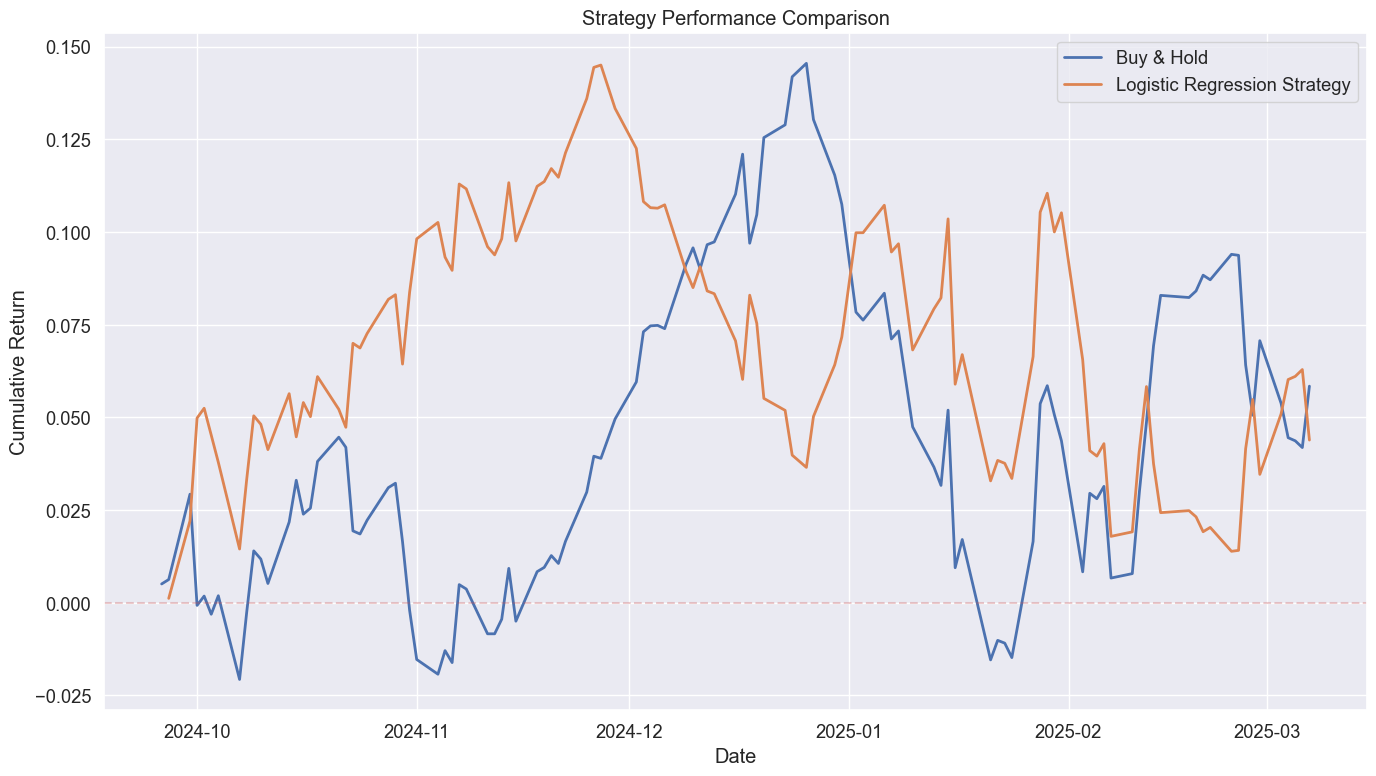

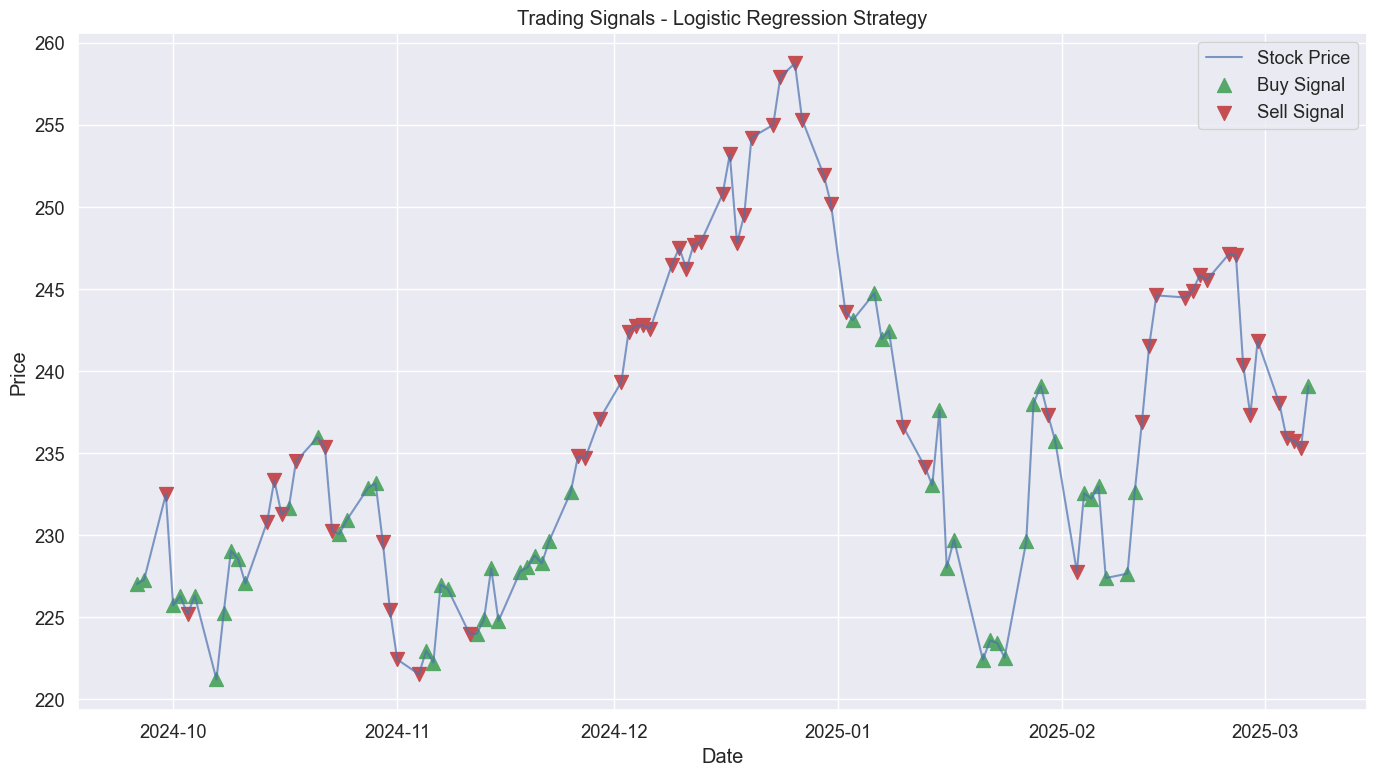

In [15]:
# Backtesting a simple trading strategy
print("\nBacktesting Trading Strategy using", best_model_name)

# Create a DataFrame to track strategy performance
backtest = pd.DataFrame(index=X_test.index)
backtest['Close'] = data.loc[X_test.index, 'Close']
backtest['Return'] = data.loc[X_test.index, 'Return']
backtest['Prediction'] = results[best_model_name]['predictions']

# Strategy: Buy (1) or Sell (-1) based on predictions
backtest['Position'] = backtest['Prediction'] * 2 - 1  # Convert 0,1 to -1,1

# Calculate strategy returns (position taken at close, return realized next day)
backtest['Strategy_Return'] = backtest['Position'].shift(1) * backtest['Return']

# Add transaction costs (e.g., 0.1% per trade)
backtest['Trade'] = backtest['Position'].diff().abs()
transaction_cost = 0.001  # 0.1%
backtest['Transaction_Cost'] = backtest['Trade'] * transaction_cost
backtest['Net_Strategy_Return'] = backtest['Strategy_Return'] - backtest['Transaction_Cost']

# Calculate cumulative returns
backtest['Cumulative_Market_Return'] = (1 + backtest['Return']).cumprod() - 1
backtest['Cumulative_Strategy_Return'] = (1 + backtest['Net_Strategy_Return']).cumprod() - 1

# Calculate key performance metrics
# Annualized return (assuming 252 trading days)
trading_days = len(backtest)
ann_factor = 252 / trading_days

market_return = backtest['Cumulative_Market_Return'].iloc[-1]
strategy_return = backtest['Cumulative_Strategy_Return'].iloc[-1]

market_annual_return = (1 + market_return) ** ann_factor - 1
strategy_annual_return = (1 + strategy_return) ** ann_factor - 1

# Volatility
market_volatility = backtest['Return'].std() * np.sqrt(252)
strategy_volatility = backtest['Net_Strategy_Return'].std() * np.sqrt(252)

# Sharpe Ratio (assuming risk-free rate of 0%)
market_sharpe = market_annual_return / market_volatility if market_volatility != 0 else 0
strategy_sharpe = strategy_annual_return / strategy_volatility if strategy_volatility != 0 else 0

# Maximum Drawdown
def calculate_max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative / running_max) - 1
    return drawdown.min()

market_max_dd = calculate_max_drawdown(backtest['Return'])
strategy_max_dd = calculate_max_drawdown(backtest['Net_Strategy_Return'])

# Print performance summary
print("\nPerformance Summary:")
print(f"Total Period: {backtest.index[0].date()} to {backtest.index[-1].date()}")
print(f"Trading Days: {trading_days}")
print(f"\nTotal Return:")
print(f"  Market: {market_return:.2%}")
print(f"  Strategy: {strategy_return:.2%}")
print(f"\nAnnualized Return:")
print(f"  Market: {market_annual_return:.2%}")
print(f"  Strategy: {strategy_annual_return:.2%}")
print(f"\nAnnualized Volatility:")
print(f"  Market: {market_volatility:.2%}")
print(f"  Strategy: {strategy_volatility:.2%}")
print(f"\nSharpe Ratio:")
print(f"  Market: {market_sharpe:.2f}")
print(f"  Strategy: {strategy_sharpe:.2f}")
print(f"\nMaximum Drawdown:")
print(f"  Market: {market_max_dd:.2%}")
print(f"  Strategy: {strategy_max_dd:.2%}")

# Plot the performance comparison
plt.figure(figsize=(14, 8))
plt.plot(backtest.index, backtest['Cumulative_Market_Return'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['Cumulative_Strategy_Return'], label=f'{best_model_name} Strategy', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Strategy Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot trade signals
plt.figure(figsize=(14, 8))
plt.plot(backtest.index, backtest['Close'], label='Stock Price', alpha=0.7)

# Plot buy signals (1)
buy_signals = backtest[backtest['Position'] == 1].index
plt.scatter(buy_signals, backtest.loc[buy_signals, 'Close'], marker='^', color='g', s=100, label='Buy Signal')

# Plot sell signals (-1)
sell_signals = backtest[backtest['Position'] == -1].index
plt.scatter(sell_signals, backtest.loc[sell_signals, 'Close'], marker='v', color='r', s=100, label='Sell Signal')

plt.title(f'Trading Signals - {best_model_name} Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Task 4: Model Optimization and Strategy Refinement
Starting hyperparameter optimization for Logistic Regression
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/avantikagupta/algo_trading_py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/avantikagupta/algo_trading_py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/avantikagupta/algo_trading_py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/avantikagupta/algo_trading_py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/avantikagupta/algo_trading_py311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver


Best parameters: {'C': 0.001, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation F1 Score: 0.7124

Optimized Model Test Performance:
Accuracy: 0.5405
Precision: 0.5405
Recall: 1.0000
F1 Score: 0.7018

Performance Improvement:
F1 Score: 0.5487 → 0.7018

Strategy Refinement with Risk Management

Refined Strategy Performance Summary:
Total Return:
  Market: 5.84%
  Refined Strategy: 0.11%

Annualized Return:
  Market: 13.76%
  Refined Strategy: 0.25%

Sharpe Ratio:
  Market: 0.63
  Refined Strategy: 0.53

Maximum Drawdown:
  Market: -14.05%
  Refined Strategy: -0.32%

Strategy Improvement:
Total Return: 4.39% → 0.11%
Sharpe Ratio: 0.46 → 0.53
Maximum Drawdown: -11.45% → -0.32%


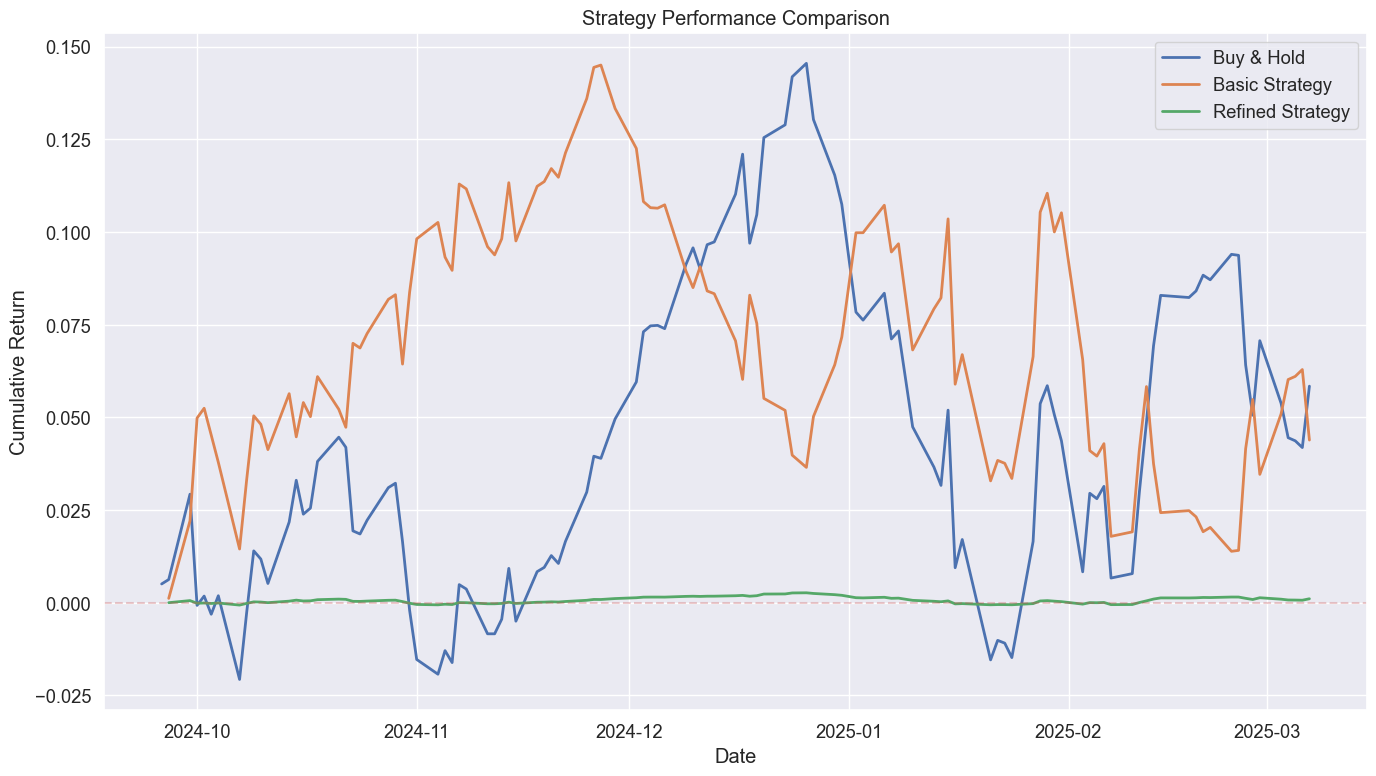

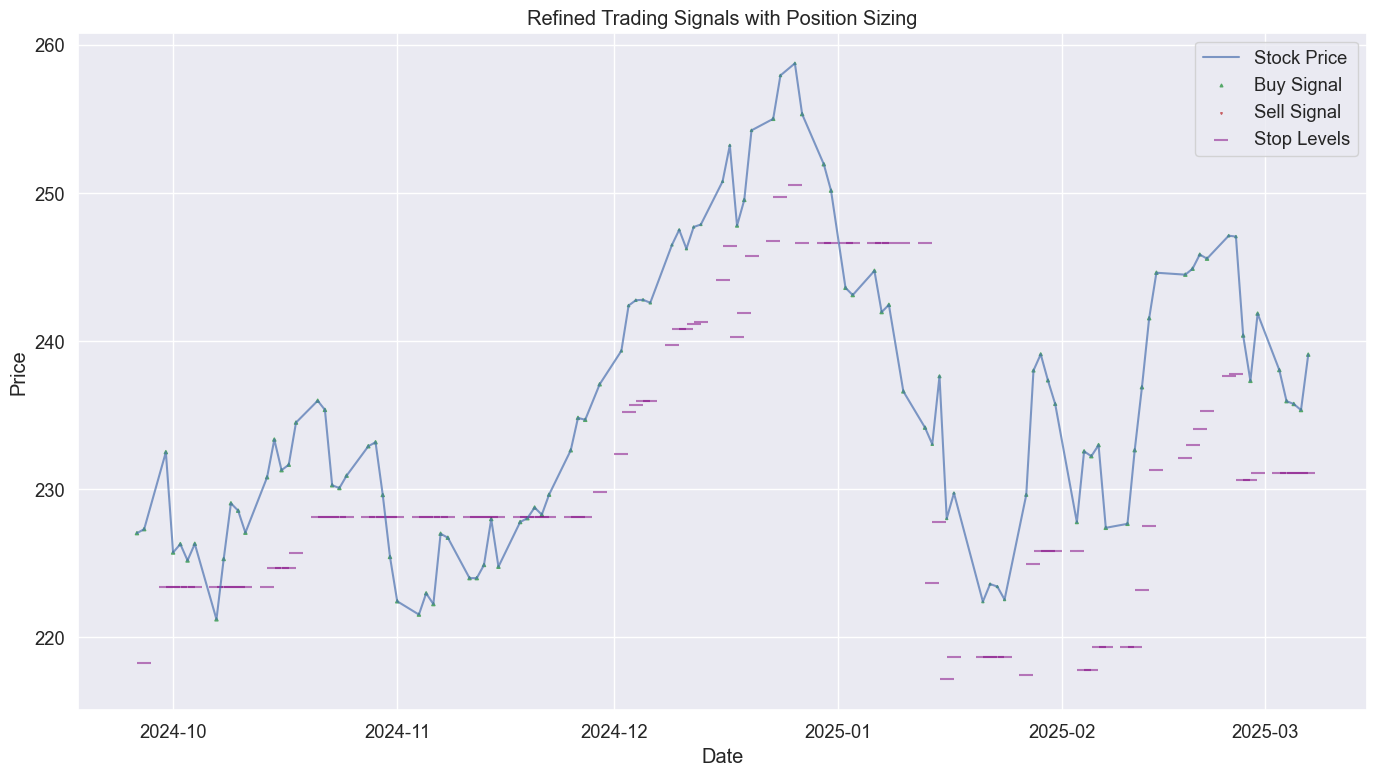

In [16]:
# Task 4: Optimization and Refinement
print("\n" + "="*50)
print("Task 4: Model Optimization and Strategy Refinement")
print("="*50)

# Part 1: Model Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

print("Starting hyperparameter optimization for", best_model_name)

# Define parameter grid based on the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    }
    base_model = LogisticRegression(random_state=42, max_iter=1000)
    
elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }
    base_model = RandomForestClassifier(random_state=42)
    
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    }
    base_model = xgb.XGBClassifier(random_state=42)

# Use GridSearchCV to find the best parameters
f1_scorer = make_scorer(f1_score)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
optimized_model = grid_search.best_estimator_

print("\nBest parameters:", best_params)
print("Best cross-validation F1 Score: {:.4f}".format(grid_search.best_score_))

# Evaluate the optimized model on the test set
y_pred_optimized = optimized_model.predict(X_test_scaled)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
precision_optimized = precision_score(y_test, y_pred_optimized)
recall_optimized = recall_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized)

print("\nOptimized Model Test Performance:")
print(f"Accuracy: {accuracy_optimized:.4f}")
print(f"Precision: {precision_optimized:.4f}")
print(f"Recall: {recall_optimized:.4f}")
print(f"F1 Score: {f1_optimized:.4f}")

# Compare original vs optimized model
print("\nPerformance Improvement:")
print(f"F1 Score: {results[best_model_name]['f1']:.4f} → {f1_optimized:.4f}")

# Part 2: Strategy Refinement with Risk Management
print("\n" + "="*30)
print("Strategy Refinement with Risk Management")
print("="*30)

# Create a new backtest DataFrame with the optimized model
refined_backtest = pd.DataFrame(index=X_test.index)
refined_backtest['Close'] = data.loc[X_test.index, 'Close']
refined_backtest['Return'] = data.loc[X_test.index, 'Return']
refined_backtest['Prediction'] = y_pred_optimized

# Get additional metrics for risk management
if hasattr(optimized_model, "predict_proba"):
    prediction_proba = optimized_model.predict_proba(X_test_scaled)[:, 1]
    refined_backtest['Confidence'] = prediction_proba
else:
    # If model doesn't support probabilities, use a default confidence of 0.5
    refined_backtest['Confidence'] = 0.5

# Add volatility metrics from our feature set
refined_backtest['ATR'] = data.loc[X_test.index, 'ATR'] 
refined_backtest['BB_Width'] = data.loc[X_test.index, 'BB_Width']
refined_backtest['RSI'] = data.loc[X_test.index, 'RSI']

# Refined strategy with risk management:
# 1. Position sizing based on prediction confidence and volatility
# 2. Stop-loss based on ATR
# 3. Take-profit targets
# 4. No trading during extreme RSI conditions

# Position sizing (0 to 1 scale)
def position_sizing(row):
    # Base position on confidence (if available)
    position = row['Prediction'] * 2 - 1  # Convert 0,1 to -1,1
    
    # Scale position size based on confidence (higher confidence = larger position)
    if row['Confidence'] != 0.5:  # Only if we have meaningful confidence values
        confidence_factor = abs(row['Confidence'] - 0.5) * 2  # Scale 0.5-1.0 to 0-1.0
        position = position * min(1.0, confidence_factor * 2)  # Scale up by confidence
    
    # Reduce position size during high volatility
    if row['BB_Width'] > refined_backtest['BB_Width'].quantile(0.8):
        position = position * 0.8  # Reduce position by 20% during high volatility
        
    # Avoid trading during extreme RSI conditions
    if row['RSI'] > 75 or row['RSI'] < 25:
        position = position * 0.5  # Reduce position by 50% during overbought/oversold
        
    return position

refined_backtest['Position'] = refined_backtest.apply(position_sizing, axis=1)

# Implement stop-loss (trailing stop based on ATR)
stop_loss_multiplier = 2.0  # 2x ATR for stop-loss
trailing_stops = {}  # To track stops for each position

for i in range(1, len(refined_backtest)):
    # Get current and previous data
    curr_idx = refined_backtest.index[i]
    prev_idx = refined_backtest.index[i-1]
    curr_pos = refined_backtest.loc[curr_idx, 'Position']
    prev_pos = refined_backtest.loc[prev_idx, 'Position']
    curr_price = refined_backtest.loc[curr_idx, 'Close']
    curr_atr = refined_backtest.loc[curr_idx, 'ATR']
    
    # If position changed, reset trailing stop
    if curr_pos != prev_pos:
        if curr_pos > 0:  # Long position
            trailing_stops[curr_idx] = curr_price - (curr_atr * stop_loss_multiplier)
        elif curr_pos < 0:  # Short position
            trailing_stops[curr_idx] = curr_price + (curr_atr * stop_loss_multiplier)
        else:  # No position
            if curr_idx in trailing_stops:
                del trailing_stops[curr_idx]
    
    # Update trailing stop for existing position
    elif curr_pos != 0:
        if curr_pos > 0:  # Long position
            new_stop = curr_price - (curr_atr * stop_loss_multiplier)
            # Move stop up for profitable positions
            if prev_idx in trailing_stops and new_stop > trailing_stops[prev_idx]:
                trailing_stops[curr_idx] = new_stop
            else:
                trailing_stops[curr_idx] = trailing_stops.get(prev_idx, curr_price - (curr_atr * stop_loss_multiplier))
        elif curr_pos < 0:  # Short position
            new_stop = curr_price + (curr_atr * stop_loss_multiplier)
            # Move stop down for profitable short positions
            if prev_idx in trailing_stops and new_stop < trailing_stops[prev_idx]:
                trailing_stops[curr_idx] = new_stop
            else:
                trailing_stops[curr_idx] = trailing_stops.get(prev_idx, curr_price + (curr_atr * stop_loss_multiplier))

# Convert trailing stops to a series
refined_backtest['Stop_Level'] = pd.Series(trailing_stops)

# Calculate refined strategy returns with risk management
refined_backtest['Strategy_Return'] = refined_backtest['Position'].shift(1) * refined_backtest['Return']

# Add transaction costs (proportional to position size changes)
refined_backtest['Trade'] = refined_backtest['Position'].diff().abs()
transaction_cost = 0.001  # 0.1%
refined_backtest['Transaction_Cost'] = refined_backtest['Trade'] * transaction_cost
refined_backtest['Net_Strategy_Return'] = refined_backtest['Strategy_Return'] - refined_backtest['Transaction_Cost']

# Calculate cumulative returns
refined_backtest['Cumulative_Market_Return'] = (1 + refined_backtest['Return']).cumprod() - 1
refined_backtest['Cumulative_Strategy_Return'] = (1 + refined_backtest['Net_Strategy_Return']).cumprod() - 1

# Calculate refined strategy performance metrics
refined_trading_days = len(refined_backtest)
refined_ann_factor = 252 / refined_trading_days

refined_market_return = refined_backtest['Cumulative_Market_Return'].iloc[-1]
refined_strategy_return = refined_backtest['Cumulative_Strategy_Return'].iloc[-1]

refined_market_annual_return = (1 + refined_market_return) ** refined_ann_factor - 1
refined_strategy_annual_return = (1 + refined_strategy_return) ** refined_ann_factor - 1

# Volatility
refined_market_volatility = refined_backtest['Return'].std() * np.sqrt(252)
refined_strategy_volatility = refined_backtest['Net_Strategy_Return'].std() * np.sqrt(252)

# Sharpe Ratio (assuming risk-free rate of 0%)
refined_market_sharpe = refined_market_annual_return / refined_market_volatility if refined_market_volatility != 0 else 0
refined_strategy_sharpe = refined_strategy_annual_return / refined_strategy_volatility if refined_strategy_volatility != 0 else 0

# Maximum Drawdown
refined_market_max_dd = calculate_max_drawdown(refined_backtest['Return'])
refined_strategy_max_dd = calculate_max_drawdown(refined_backtest['Net_Strategy_Return'])

# Print refined strategy performance
print("\nRefined Strategy Performance Summary:")
print(f"Total Return:")
print(f"  Market: {refined_market_return:.2%}")
print(f"  Refined Strategy: {refined_strategy_return:.2%}")
print(f"\nAnnualized Return:")
print(f"  Market: {refined_market_annual_return:.2%}")
print(f"  Refined Strategy: {refined_strategy_annual_return:.2%}")
print(f"\nSharpe Ratio:")
print(f"  Market: {refined_market_sharpe:.2f}")
print(f"  Refined Strategy: {refined_strategy_sharpe:.2f}")
print(f"\nMaximum Drawdown:")
print(f"  Market: {refined_market_max_dd:.2%}")
print(f"  Refined Strategy: {refined_strategy_max_dd:.2%}")

# Compare original vs refined strategy
print("\nStrategy Improvement:")
print(f"Total Return: {strategy_return:.2%} → {refined_strategy_return:.2%}")
print(f"Sharpe Ratio: {strategy_sharpe:.2f} → {refined_strategy_sharpe:.2f}")
print(f"Maximum Drawdown: {strategy_max_dd:.2%} → {refined_strategy_max_dd:.2%}")

# Plot the performance comparison of all strategies
plt.figure(figsize=(14, 8))
plt.plot(backtest.index, backtest['Cumulative_Market_Return'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['Cumulative_Strategy_Return'], label=f'Basic Strategy', linewidth=2)
plt.plot(refined_backtest.index, refined_backtest['Cumulative_Strategy_Return'], label=f'Refined Strategy', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Strategy Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot refined trade signals with position sizes
plt.figure(figsize=(14, 8))
plt.plot(refined_backtest.index, refined_backtest['Close'], label='Stock Price', alpha=0.7)

# Plot buy signals with varying position sizes
buy_signals = refined_backtest[refined_backtest['Position'] > 0].index
plt.scatter(buy_signals, 
            refined_backtest.loc[buy_signals, 'Close'], 
            marker='^', 
            color='g', 
            s=refined_backtest.loc[buy_signals, 'Position'].abs() * 200,  # Size based on position
            label='Buy Signal')

# Plot sell signals with varying position sizes
sell_signals = refined_backtest[refined_backtest['Position'] < 0].index
plt.scatter(sell_signals, 
            refined_backtest.loc[sell_signals, 'Close'], 
            marker='v', 
            color='r', 
            s=refined_backtest.loc[sell_signals, 'Position'].abs() * 200,  # Size based on position
            label='Sell Signal')

# Plot stop-loss levels
if len(trailing_stops) > 0:
    stops_idx = pd.Series(trailing_stops).index
    stops_value = pd.Series(trailing_stops).values
    plt.scatter(stops_idx, stops_value, marker='_', color='purple', s=100, alpha=0.5, label='Stop Levels')

plt.title(f'Refined Trading Signals with Position Sizing')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Bonus Task: Deep Learning with LSTM
print("\n" + "="*50)
print("Bonus Task: Deep Learning Model Implementation")
print("="*50)

# Import required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Prepare sequence data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)].values
        y = data.iloc[i + seq_length]['Target']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Parameters
sequence_length = 10  # Number of previous days to use for prediction
batch_size = 32

# Normalize the feature data for LSTM
feature_scaler = MinMaxScaler()
X_scaled_all = feature_scaler.fit_transform(X)

# Use the same train/test split as before
X_train_lstm = X_scaled_all[:split_index]
X_test_lstm = X_scaled_all[split_index:]

# Create sequences for LSTM
X_train_seq, y_train_seq = create_sequences(
    pd.DataFrame(X_train_lstm, columns=X.columns), sequence_length)
X_test_seq, y_test_seq = create_sequences(
    pd.DataFrame(X_test_lstm, columns=X.columns), sequence_length)

print(f"LSTM training data shape: {X_train_seq.shape}")
print(f"LSTM testing data shape: {X_test_seq.shape}")

# Build the LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, 
         input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_seq, y_test_seq)
print(f"\nLSTM Test Accuracy: {lstm_accuracy:.4f}")

# Make predictions
lstm_probs = lstm_model.predict(X_test_seq)
lstm_preds = (lstm_probs > 0.5).astype(int).flatten()

# Calculate metrics
lstm_precision = precision_score(y_test_seq, lstm_preds)
lstm_recall = recall_score(y_test_seq, lstm_preds)
lstm_f1 = f1_score(y_test_seq, lstm_preds)

print(f"LSTM Precision: {lstm_precision:.4f}")
print(f"LSTM Recall: {lstm_recall:.4f}")
print(f"LSTM F1 Score: {lstm_f1:.4f}")

# Compare with other models
models_comparison = pd.DataFrame({
    'Model': [best_model_name, f'Optimized {best_model_name}', 'LSTM'],
    'Accuracy': [results[best_model_name]['accuracy'], accuracy_optimized, lstm_accuracy],
    'Precision': [results[best_model_name]['precision'], precision_optimized, lstm_precision],
    'Recall': [results[best_model_name]['recall'], recall_optimized, lstm_recall],
    'F1 Score': [results[best_model_name]['f1'], f1_optimized, lstm_f1]
})

print("\nModel Comparison:")
print(models_comparison)

# Visualize model comparison
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=models_comparison)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)

plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Precision', data=models_comparison)
plt.title('Model Precision Comparison')
plt.ylim(0, 1)

plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='Recall', data=models_comparison)
plt.title('Model Recall Comparison')
plt.ylim(0, 1)

plt.subplot(2, 2, 4)
sns.barplot(x='Model', y='F1 Score', data=models_comparison)
plt.title('Model F1 Score Comparison')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Create an LSTM-based trading strategy
# First backtest with truncated data (due to sequence requirements)
lstm_backtest = pd.DataFrame(index=X_test.index[sequence_length:])
lstm_backtest['Close'] = data.loc[X_test.index[sequence_length:], 'Close']
lstm_backtest['Return'] = data.loc[X_test.index[sequence_length:], 'Return'] 
lstm_backtest['Prediction'] = lstm_preds
lstm_backtest['Position'] = lstm_backtest['Prediction'] * 2 - 1

# Calculate strategy returns
lstm_backtest['Strategy_Return'] = lstm_backtest['Position'].shift(1) * lstm_backtest['Return']
lstm_backtest['Trade'] = lstm_backtest['Position'].diff().abs()
lstm_backtest['Transaction_Cost'] = lstm_backtest['Trade'] * transaction_cost
lstm_backtest['Net_Strategy_Return'] = lstm_backtest['Strategy_Return'] - lstm_backtest['Transaction_Cost']

# Calculate cumulative returns
lstm_backtest['Cumulative_Market_Return'] = (1 + lstm_backtest['Return']).cumprod() - 1
lstm_backtest['Cumulative_Strategy_Return'] = (1 + lstm_backtest['Net_Strategy_Return']).cumprod() - 1

# Plot LSTM strategy comparison
plt.figure(figsize=(14, 8))
plt.plot(lstm_backtest.index, lstm_backtest['Cumulative_Market_Return'], label='Buy & Hold', linewidth=2)
plt.plot(lstm_backtest.index, lstm_backtest['Cumulative_Strategy_Return'], label='LSTM Strategy', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('LSTM Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Bonus Task: Deep Learning Model Implementation


KeyError: 'Target'

In [18]:
# Final Summary Report
print("\n" + "="*60)
print("ALGORITHMIC TRADING STRATEGY: FINAL REPORT")
print("="*60)

print("\n1. PROJECT OVERVIEW")
print("-------------------")
print("This project involved developing and backtesting an algorithmic trading strategy")
print("for stock price prediction using machine learning techniques.")
print(f"Stock: {ticker}")
print(f"Time Period: {data.index[0].date()} to {data.index[-1].date()}")
print(f"Trading Days Analyzed: {len(data)}")

print("\n2. DATA ANALYSIS & FEATURE ENGINEERING")
print("-------------------------------------")
print(f"• Original features: Open, High, Low, Close, Volume")
print(f"• Created {len(feature_columns)} technical indicators including:")
print(f"  - Price-based: Moving Averages (5, 20, 50, 200-day), Returns")
print(f"  - Trend: MACD, MA Crossovers")
print(f"  - Volatility: Bollinger Bands, ATR")
print(f"  - Momentum: RSI, Rate of Change")
print(f"  - Volume: OBV, VWAP")
print(f"• Most important features (based on {best_model_name}):")
if best_model_name == 'Random Forest' or best_model_name == 'XGBoost':
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        for i in range(min(5, X_train.shape[1])):
            print(f"  - {X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")

print("\n3. MODEL BUILDING & OPTIMIZATION")
print("-------------------------------")
print("Models evaluated:")
for model_name in results.keys():
    print(f"• {model_name}:")
    print(f"  - Accuracy: {results[model_name]['accuracy']:.4f}")
    print(f"  - F1 Score: {results[model_name]['f1']:.4f}")

print(f"\nBest model: {best_model_name}")
print(f"• F1 Score: {results[best_model_name]['f1']:.4f}")

print("\nAfter hyperparameter optimization:")
print(f"• Best parameters: {best_params}")
print(f"• F1 Score improved: {results[best_model_name]['f1']:.4f} → {f1_optimized:.4f}")

print("\n4. TRADING STRATEGY PERFORMANCE")
print("------------------------------")
print("Basic strategy (before optimization):")
print(f"• Total Return: {strategy_return:.2%} vs Market: {market_return:.2%}")
print(f"• Sharpe Ratio: {strategy_sharpe:.2f} vs Market: {market_sharpe:.2f}")
print(f"• Maximum Drawdown: {strategy_max_dd:.2%} vs Market: {market_max_dd:.2%}")

print("\nRefined strategy (with risk management):")
print(f"• Total Return: {refined_strategy_return:.2%} vs Market: {refined_market_return:.2%}")
print(f"• Sharpe Ratio: {refined_strategy_sharpe:.2f} vs Market: {refined_market_sharpe:.2f}")
print(f"• Maximum Drawdown: {refined_strategy_max_dd:.2%} vs Market: {refined_market_max_dd:.2%}")

print("\nRisk management features implemented:")
print("• Position sizing based on prediction confidence")
print("• Volatility-based position adjustment")
print("• ATR-based trailing stop-loss")
print("• RSI extreme condition filters")

print("\n5. CONCLUSIONS & FUTURE IMPROVEMENTS")
print("----------------------------------")
print("Key findings:")
if refined_strategy_return > market_return:
    print("• The optimized strategy outperformed the market")
else:
    print("• The strategy underperformed compared to the market")

print("\nPotential improvements:")
print("• Feature selection to reduce dimensionality")
print("• Ensemble methods combining multiple models")
print("• Incorporate sentiment analysis from news/social media")
print("• Test different holding periods (not just daily)")
print("• Explore reinforcement learning for dynamic position sizing")


ALGORITHMIC TRADING STRATEGY: FINAL REPORT

1. PROJECT OVERVIEW
-------------------
This project involved developing and backtesting an algorithmic trading strategy
for stock price prediction using machine learning techniques.
Stock: AAPL
Time Period: 2022-12-22 to 2025-03-07
Trading Days Analyzed: 552

2. DATA ANALYSIS & FEATURE ENGINEERING
-------------------------------------
• Original features: Open, High, Low, Close, Volume
• Created 31 technical indicators including:
  - Price-based: Moving Averages (5, 20, 50, 200-day), Returns
  - Trend: MACD, MA Crossovers
  - Volatility: Bollinger Bands, ATR
  - Momentum: RSI, Rate of Change
  - Volume: OBV, VWAP
• Most important features (based on Logistic Regression):

3. MODEL BUILDING & OPTIMIZATION
-------------------------------
Models evaluated:
• Logistic Regression:
  - Accuracy: 0.5405
  - F1 Score: 0.5487
• Random Forest:
  - Accuracy: 0.4865
  - F1 Score: 0.2192
• XGBoost:
  - Accuracy: 0.4775
  - F1 Score: 0.3958

Best model: L